### Разработка ml-модели для сопоставления текстов музыкальных произведений и для поиска каверов.

## 1. Анализ данных

In [39]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=8a1e1fb5381ca83e747a35fff08ad2c433def1bdb51c11c5e79bafd714c73391
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [40]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.9 MB/s eta 0:00:00


In [42]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [4]:
covers = pd.read_json('/content/drive/MyDrive/YaMusic/covers.json', lines=True)
lyrics = pd.read_json('/content/drive/MyDrive/YaMusic/lyrics.json', lines=True)
meta = pd.read_json('/content/drive/MyDrive/YaMusic/meta.json', lines=True)

Рассмотрим информацию в датасетах.

In [5]:
datas = [covers, lyrics, meta]
for i in range(len(datas)):
    print(datas[i].head())
    print()

                  original_track_id                          track_id  \
0  eeb69a3cb92300456b6a5f4162093851  eeb69a3cb92300456b6a5f4162093851   
1  fe7ee8fc1959cc7214fa21c4840dff0a  fe7ee8fc1959cc7214fa21c4840dff0a   
2  cd89fef7ffdd490db800357f47722b20  cd89fef7ffdd490db800357f47722b20   
3  995665640dc319973d3173a74a03860c  995665640dc319973d3173a74a03860c   
4                              None  d6288499d0083cc34e60a077b7c4b3e1   

  track_remake_type  
0          ORIGINAL  
1          ORIGINAL  
2          ORIGINAL  
3          ORIGINAL  
4             COVER  

                            lyricId  \
0  a951f9504e89759e9d23039b7b17ec14   
1  0c749bc3f01eb8e6cf986fa14ccfc585   
2  e2c8830fbc86e5964478243099eec23a   
3  e2c8830fbc86e5964478243099eec23a   
4  7624653ca8522ba93470843c74961b7d   

                                                text  \
0  Живу сейчас обломами, обломками не той любви\n...   
1  Tell me your fable\nA fable\nTell me your fabl...   
2  You're ashamed about a

In [6]:
for i in range(len(datas)):
    print(datas[i].info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   track_id  71768 non-null  object 
 1   dttm      71768 non-null  float64
 

Присутствуют пропуски в language, isrc, original_track_id.

Посмотрим на данные с пропусками.

In [7]:
meta[meta['language'].isna()]

,track_id,dttm,title,language,isrc,genres,duration
2,955f2aafe8717908c140bf122ba4172d,1.637768e+12,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,1.637768e+12,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,1.637768e+12,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
5,551331ee1444de6658e71933eb7f57a2,1.637768e+12,La Ultima Vez,None,QZNJZ2166034,"[FOLK, LATINFOLK]",173000.0
6,2be8bb01bb1aeef0908524dc11935a88,1.637768e+12,Homenaje a Pastor de los Santos,None,QZNJZ2122553,"[FOLK, LATINFOLK]",192100.0
...,...,...,...,...,...,...,...
71759,27338fa59732e7b6a6f89ea3e9cf7611,1.560281e+12,Little Wing,None,ES71G1408072,"[ROCK, ALLROCK]",190320.0
71760,e3899173fcdfbd30ff0b07c7e0dbdbc8,1.561064e+12,Shutter Island,None,CAB391902526,[ALTERNATIVE],206650.0
71761,86f1aff8c191baf6957fcda82fe6b3c3,1.560892e+12,Diamonds,None,ES50A1900470,"[ELECTRONICS, HOUSE]",281980.0
71763,496e3bddf448fbedab6a0825382618c4,1.560399e+12,Se Preparó,None,FR2X41997633,"[FOLK, LATINFOLK]",186340.0


In [8]:
meta[meta['isrc'].isna()]

,track_id,dttm,title,language,isrc,genres,duration
2151,16645e5e127d29b8bbbea6375a9344e2,1.640293e+12,Глава 4. Урок рисования,None,None,[FAIRYTALES],559040.0
2185,96f75d124808c84d823f09add1b6855c,1.640250e+12,Чижик-пыжик (А. Пинегин — А. Усачев),None,None,[FORCHILDREN],144560.0
2238,77bf68f7657ba9f87ee6ae7af3dc8999,1.640272e+12,Повторение счёта до 12,None,None,[FORCHILDREN],97720.0
2317,fb97e639240fb249756b40e0f88387cb,1.640334e+12,Глава 12. Пятно,None,None,[FAIRYTALES],103280.0
3838,be76b11b186c8f8a6afb34a23f64b132,1.642680e+12,Americano,None,None,[],225800.0
...,...,...,...,...,...,...,...
71703,fefdb000f83cc54a6cd15cd330e94804,1.559822e+12,Buona Sera Ciao Ciao,None,None,[POP],222300.0
71704,bb7c35e220d721f5271f00993b65c150,1.559822e+12,Eray,None,None,[POP],249880.0
71705,85ae0838be340db39deda0c04f3898bb,1.559822e+12,My Heart Will Go On,None,None,[POP],286410.0
71706,f3ce217d8dc57c625002748b79dba088,1.559822e+12,What is Love,None,None,[POP],309050.0


Посмотрим распределение длительностей.

In [9]:
meta['duration'].describe()

count    7.176800e+04
mean     2.049187e+05
std      8.559854e+04
min      0.000000e+00
25%      1.613700e+05
50%      1.993950e+05
75%      2.390700e+05
max      5.487300e+06
Name: duration, dtype: float64

В датасэте присутствуют книги. Так как наша задача - рекомендация музыки, эти данные не подходят.

In [10]:
covers[covers['original_track_id'].isna()]

,original_track_id,track_id,track_remake_type
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
5,None,4da9d7b6d119db4d2d564a2197798380,COVER
6,None,2bf283c05b601f21364d052ca0ec798d,COVER
7,None,5eb13cb69b6e20dd7a42030f5936a9dc,COVER
8,None,109f91266ef89cc3690079b28abfe9a3,COVER
...,...,...,...
71581,None,ca9ef71613177a1ccf9e12e65b94e37b,COVER
71582,None,7aba7ec7d0aefd0ac3a3bc74be201853,COVER
71583,None,86c0bc5713e2817bec42e6274e0dc61c,COVER
71593,None,78b2db35476f134dc3cdfbf4d77ba034,COVER


Присутствует множество неизвестных оригинальных треков у каверов.

Проверим данные на дубликаты.

In [11]:
for i in range(len(datas)):
    print(datas[i]['track_id'].duplicated().sum())
    print()

0

1137

0



Посмотрим дубликаты.

In [12]:
duplicateRows = lyrics[lyrics.duplicated(['track_id'])]
duplicateRows

,lyricId,text,track_id
263,87966c7b6254c6298e18db41fea1b1a2,You ain't nothin' but a hound dog\nJust crocki...,ea09c90790b997b6e384d75d424b3ffe
494,74825f6c746beceb4da57cf80d7d6c10,For the longest time we jamming at the party\n...,dec84e10ae3ecc5c363f495724799322
502,4d0a6051746a18c918bae3926710cb97,You were the shadow to my light\nDid you feel ...,db69f2a265624a834d6e2a1238f6f225
590,4a95959841d857516385893009cfe841,You were the shadow to my light\nDid you feel ...,db69f2a265624a834d6e2a1238f6f225
616,74c0d9fdd29e454653bfa23ec57e2808,"All my friends are heathens, take it slow\nWai...",a367959976d3ca166beb46bdf66eefd0
...,...,...,...
11398,49df743c7a49ab4b90825282434f2e72,All the crazy shit I did tonight\nThose will b...,f66bf9c7becdeb7c4ce9c70722a2009c
11399,a16a7e2d216c914a505ec01102d57bb4,Now and then I think of when we were together\...,76cee823cdb700bb2d24f6db2c34587c
11408,da374afb1d2d6fbc85b40e68d22d2ab1,As he came into the window\nIt was the sound o...,53bf57b9e4d3eed991f57a603a41c9d4
11411,22bae9d3185254ea34072c692a2cd63d,Left a good job in the city\nWorking for the m...,d5c149b59a800a6f9f61adda6d3e1b1d


Есть дубликаты по track_id, но с разным lyricId

Удалим дубликаты в текстах песен.

In [13]:
lyrics = lyrics.drop_duplicates()

Посмотрим количество каверов и оригиналов.

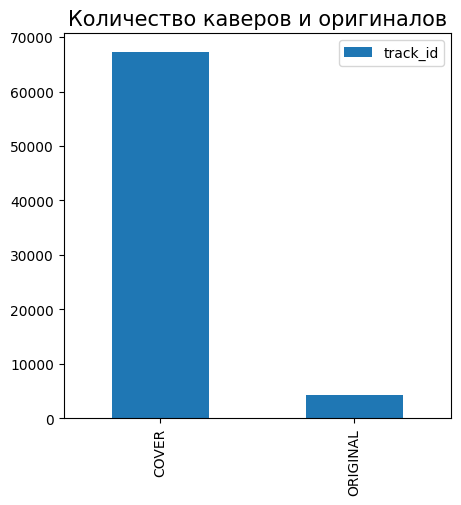

In [14]:
covers.groupby('track_remake_type').agg({'track_id':'count'}).plot(kind='bar', figsize=(5,5))
plt.title("Количество каверов и оригиналов", fontsize = 15)
plt.xlabel('')
plt.ylabel('')
plt.show()

Посмотрим распределение языков.

<Axes: >

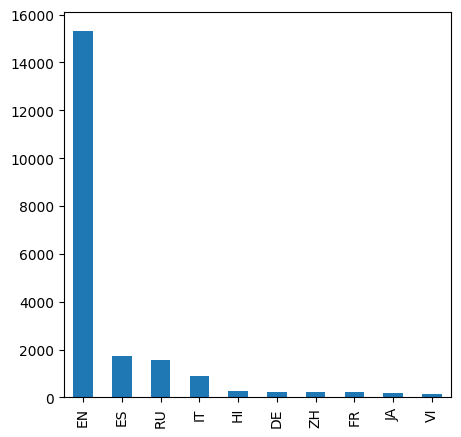

In [15]:
meta['language'].value_counts().head(10).plot(kind='bar', figsize=(5,5))

Изменим тип данных в столбце dttm.

In [16]:
meta['dttm'] = meta['dttm'].astype('datetime64[ns]')

Изучим жанры.

In [17]:
meta.sort_values(by='genres').sort_values(by='genres')

,track_id,dttm,title,language,isrc,genres,duration
15564,2ded56e085e4c60bbd376522b3dc043c,1970-01-01 00:26:01.576502,Talking in Your Sleep,None,PLS921753446,[],188500.0
71158,142bb8d1500b02cac9b911d8d9ff2e1a,1970-01-01 00:25:56.612644,I'm so Excited,None,PLS921753445,[],201630.0
71159,4fb7706d8b3b12af8423b4f5d921f85f,1970-01-01 00:25:56.612644,Shalala Lala,None,PLS921753832,[],193910.0
52703,7e43e89be73147d520807dbd0245ec44,1970-01-01 00:24:57.070986,Tage Wie Diese,None,TCADC1773260,[],288710.0
52704,72d4cd36e45a5c038cf35c95862ec632,1970-01-01 00:24:57.071016,Hello,None,TCADC1773367,[],300040.0
...,...,...,...,...,...,...,...
15686,31ecbad353f463f8006fa92296488875,1970-01-01 00:26:04.606800,Entangled,None,TCAEI1905626,"[VIDEOGAME, SOUNDTRACK]",104330.0
40869,334657a315344e1687c683de7297e4b1,1970-01-01 00:28:11.010000,Prekrasnoe Dalyoko,None,RUA1D2381941,"[VIDEOGAME, SOUNDTRACK]",120980.0
67254,b52ab7397bf1f3a05f1191537a2f9e4a,1970-01-01 00:25:41.460502,Load Out,None,CA2BN1501722,"[VIDEOGAME, SOUNDTRACK]",104430.0
15687,ce3f6a4b227d6af10f210a95d8d23cb3,1970-01-01 00:26:04.606800,Border Worlds,None,TCAEI1905653,"[VIDEOGAME, SOUNDTRACK]",102660.0


В столбце genres данные записаны в типе list. Надо сменить тип, так как такой обрабатывать сложно.
Присутствуют строки без жанра, и в датасете одна строка полностью None.

Удалим None в таблице meta.

In [18]:
meta = meta.dropna(subset=['title'])

Сделаем колонку track_id индексом для удобства объединения

In [19]:
covers = covers.set_index('track_id')
lyrics = lyrics.set_index('track_id')
meta = meta.set_index('track_id')

## 2. Предобработка данных

In [20]:
meta['genres'].value_counts().head(30)

[FOLK, LATINFOLK]              18391
[POP]                          13157
[ROCK, ALLROCK]                 5898
[ALTERNATIVE]                   3570
[FOLK]                          2645
[]                              2352
[ELECTRONICS]                   2231
[SOUNDTRACK]                    2181
[DANCE]                         2166
[SPIRITUAL]                     1552
[RAP]                           1531
[POP, RUSPOP]                   1436
[CLASSICAL, CLASSICALMUSIC]      980
[JAZZ]                           818
[CLASSICMETAL, METAL]            666
[RUSRAP, RAP]                    645
[FOREIGNBARD, BARD]              581
[METAL]                          558
[COUNTRY]                        502
[PUNK]                           500
[CLASSICALMUSIC, VOCAL]          467
[RELAX]                          409
[INDIE]                          402
[CHILDREN]                       387
[REGGAE, REGGAETON]              347
[FOREIGNRAP, RAP]                332
[SOUL, RNB]                      327
[

In [21]:
meta['genres'].explode()

track_id
c3b9d6a354ca008aa4518329aaa21380          DANCE
c57e3d13bbbf5322584a7e92e6f1f7ff    ELECTRONICS
955f2aafe8717908c140bf122ba4172d           FOLK
955f2aafe8717908c140bf122ba4172d      LATINFOLK
fae5a077c9956045955dde02143bd8ff           FOLK
                                       ...     
7cba0f30eaa8766d6c203eff2f3750a2            POP
26b6aca1c6a02ad0e2a939164716657e    ALTERNATIVE
d904dda141238e6ad1b428bfbb21262d    ALTERNATIVE
5731fc0a34c663a0c0082c712df15266            POP
5731fc0a34c663a0c0082c712df15266         RUSPOP
Name: genres, Length: 107285, dtype: object

При попытке использования explode() для устранения типа list создаются дубли, так как метод раскрывает list в новые строки.

Объединим таблицы.

In [22]:
df = meta.join(covers, how='left')
df = df.join(lyrics, how='left')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72905 entries, 0000757a652c12554a82002cd90cc10a to ffff9a22aa441db772206280ffb8b52e
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dttm               72905 non-null  datetime64[ns]
 1   title              72905 non-null  object        
 2   language           22870 non-null  object        
 3   isrc               72566 non-null  object        
 4   genres             72905 non-null  object        
 5   duration           72905 non-null  float64       
 6   original_track_id  5378 non-null   object        
 7   track_remake_type  72571 non-null  object        
 8   lyricId            11414 non-null  object        
 9   text               11414 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 6.1+ MB


In [24]:
df.head()

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,
0000757a652c12554a82002cd90cc10a,1970-01-01 00:27:12.244315,Dil Kyun Ye Mera Shor Kare,HI,QZPJ32103856,[POP],221540.0,None,COVER,344613f3596f8e9ee7ac2a6e92133a58,दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...
00017038a565df4b72048268e7623599,1970-01-01 00:27:36.104400,Un Hombre Normal,ES,QZN882241763,"[FOLK, LATINFOLK]",226320.0,None,COVER,fa545be436bdaaab85286b8e5d37749f,Se que nada pasara\nSi mañana no me ves\nY ten...
0002e85381698128b8b2a0f578ac2054,1970-01-01 00:27:00.341801,More Than a Feeling,None,AUXN22151479,[POP],270000.0,None,COVER,NaN,NaN
0003734c0dce387667e659709b20934e,1970-01-01 00:27:13.486088,Waltz For David,None,QZNJX2120988,"[JAZZ, CONJAZZ]",118820.0,None,COVER,NaN,NaN
000545f7357ee9a4bd1438505406875c,1970-01-01 00:22:43.032000,I'm Yours,None,USJCH1200347,[POP],248710.0,None,COVER,NaN,NaN


В данных присутствует множество пропусков. Нужно парсить данные.

Удалим пропуски в типах трека и текстах.

In [25]:
df = df.dropna(subset=['track_remake_type'])

In [26]:
df = df.dropna(subset=['text'])

Реализуем лемматизацию и очистку текста от лишних символов.

In [28]:
!python -m spacy download xx_ent_wiki_sm

2023-10-30 09:37:54.088648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-30 09:37:54.088736: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-30 09:37:54.088787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-30 09:37:56.226048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 16.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')


In [29]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words())
import spacy
nlp = spacy.load("xx_ent_wiki_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
from tqdm import tqdm

In [30]:
def lemmatize(text):

    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [31]:
def clear_text(text):
    pattern = r'[^a-zA-Zа-яА-ЯёЁ]'
    cl_text = re.sub(pattern, ' ', text)
    return ' '.join(cl_text.split())

In [32]:
df['clear_text'] = df['text']

In [34]:
df.loc[df['language'].isin(['EN', 'RU', 'ES', 'IT', 'DE', 'FR']), 'clear_text'] = df.loc[df['language'].isin(['EN', 'RU', 'ES', 'IT', 'DE', 'FR']), 'clear_text'].apply(clear_text)

In [35]:
df.head()

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text,clear_text
track_id,,,,,,,,,,,
0000757a652c12554a82002cd90cc10a,1970-01-01 00:27:12.244315,Dil Kyun Ye Mera Shor Kare,HI,QZPJ32103856,[POP],221540.0,None,COVER,344613f3596f8e9ee7ac2a6e92133a58,दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...,दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...
00017038a565df4b72048268e7623599,1970-01-01 00:27:36.104400,Un Hombre Normal,ES,QZN882241763,"[FOLK, LATINFOLK]",226320.0,None,COVER,fa545be436bdaaab85286b8e5d37749f,Se que nada pasara\nSi mañana no me ves\nY ten...,Se que nada pasara Si ma ana no me ves Y tengo...
000801d33025623d7de5b42f40b37ddf,1970-01-01 00:26:14.370000,секунду назад,RU,FRX201920397,"[RUSROCK, ALLROCK]",231790.0,000801d33025623d7de5b42f40b37ddf,ORIGINAL,dc889a9db5ff11d5bc752dd3f0e8f3fb,"Секунду назад было нежно и тихо\nЛетали, шепта...",Секунду назад было нежно и тихо Летали шептали...
0014e3765c38c9f86fa57e5c40ff8910,1970-01-01 00:25:44.734800,Don't Stop Believing,EN,ITG271900170,"[CLASSICMETAL, METAL]",283870.0,None,COVER,6556b4fc349dceff23118fdc99f39e97,Just a small town girl\nLivin' in a lonely wor...,Just a small town girl Livin in a lonely world...
0016ea67c5fd2d71eee4b8c583d3a6b7,1970-01-01 00:25:45.170134,Hotel California,None,QZ5AB1961531,"[ROCK, ALLROCK]",433270.0,None,COVER,8bffc092ba71ae5fddadff5328f5ed00,On a dark desert highway\nCool wind in my hair...,On a dark desert highway\nCool wind in my hair...


In [38]:
df['clear_text'].apply(lemmatize)

track_id
0000757a652c12554a82002cd90cc10a    दिल क्यूँ ये मेरा शोर करे ? \n दिल क्यूँ ये मे...
00017038a565df4b72048268e7623599    Se que nada pasara Si ma ana no I ves Y tengo ...
000801d33025623d7de5b42f40b37ddf    Секунду назад было нежно и тихо Летали шептали...
0014e3765c38c9f86fa57e5c40ff8910    just a small town girl Livin in a lonely world...
0016ea67c5fd2d71eee4b8c583d3a6b7    on a dark desert highway \n Cool wind in my ha...
                                                          ...                        
ffed644410f9ae8c0b4668dfe7c31944    I m hold on I m hold on so hard I try so hard ...
ffedc83d35554da07be06a28da6da18a    I close my eye and I can see the world that be...
fff177e8cb2740a02ee8a5fbe77268fb    ты день за днём познавал этот мир Встал пошёл ...
fffa6b630f94c204f6bce9e0711eaf81    o minha maconha \n Minha torcida \n Minha quer...
ffff9a22aa441db772206280ffb8b52e    tonight \n be no darkness tonight \n hold tigh...
Name: clear_text, Length: 11097, dtype: objec

LaBSE

In [43]:
model = SentenceTransformer('sentence-transformers/LaBSE')

In [44]:
df_without_nan = df[df['clear_text'].notna()]
df_without_nan['clear_text'].head(100)

track_id
0000757a652c12554a82002cd90cc10a    दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...
00017038a565df4b72048268e7623599    Se que nada pasara Si ma ana no me ves Y tengo...
000801d33025623d7de5b42f40b37ddf    Секунду назад было нежно и тихо Летали шептали...
0014e3765c38c9f86fa57e5c40ff8910    Just a small town girl Livin in a lonely world...
0016ea67c5fd2d71eee4b8c583d3a6b7    On a dark desert highway\nCool wind in my hair...
                                                          ...                        
02463cf8dd7ccd8283ac029c9692fd21    First when there s nothing but a slow glowing ...
02595d6adc91939d4aa9151cf3df299c    Breaking my back just to know your name Sevent...
025b0cb1df23e592310dbd6726fb8bee    Quem é você\nQue toda noite liga pra mim\nQue ...
025d65f7935b274f32da10d6cea2b71d    Desde muy ni a siempre actu con timidez Con el...
02623d3d216ad4eac2c3aaea88c996e3    Под сиреневой луной я бегу к тебе домой На ули...
Name: clear_text, Length: 100, dtype: object

In [45]:
embeddings = model.encode(df_without_nan['clear_text'].head(100))
print(embeddings)

[[-0.06922301 -0.02750809 -0.0557544  ... -0.02462904 -0.05165264
  -0.01176211]
 [-0.04253892 -0.03233457 -0.01705603 ... -0.02824892 -0.05561522
  -0.06040136]
 [-0.05189064 -0.03118512 -0.05455518 ... -0.03469861 -0.03891388
  -0.012658  ]
 ...
 [-0.03386588 -0.05695167 -0.03128488 ... -0.03580378 -0.05531958
  -0.00888631]
 [-0.0497973  -0.06211301 -0.03230183 ... -0.03632086 -0.06163216
  -0.04191522]
 [-0.05415838 -0.05235174 -0.0316711  ... -0.0121949  -0.05016779
  -0.04827648]]


In [46]:
df['clear_title'] = df['title']

In [47]:
df.loc[df['language'].isin(['EN', 'RU', 'ES', 'IT', 'DE', 'FR']), 'title'] = df.loc[df['language'].isin(['EN', 'RU', 'ES', 'IT', 'DE', 'FR']), 'title'].apply(clear_text)

In [48]:
df.head(20)

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text,clear_text,clear_title
track_id,,,,,,,,,,,,
0000757a652c12554a82002cd90cc10a,1970-01-01 00:27:12.244315,Dil Kyun Ye Mera Shor Kare,HI,QZPJ32103856,[POP],221540.0,None,COVER,344613f3596f8e9ee7ac2a6e92133a58,दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...,दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...,Dil Kyun Ye Mera Shor Kare
00017038a565df4b72048268e7623599,1970-01-01 00:27:36.104400,Un Hombre Normal,ES,QZN882241763,"[FOLK, LATINFOLK]",226320.0,None,COVER,fa545be436bdaaab85286b8e5d37749f,Se que nada pasara\nSi mañana no me ves\nY ten...,Se que nada pasara Si ma ana no me ves Y tengo...,Un Hombre Normal
000801d33025623d7de5b42f40b37ddf,1970-01-01 00:26:14.370000,секунду назад,RU,FRX201920397,"[RUSROCK, ALLROCK]",231790.0,000801d33025623d7de5b42f40b37ddf,ORIGINAL,dc889a9db5ff11d5bc752dd3f0e8f3fb,"Секунду назад было нежно и тихо\nЛетали, шепта...",Секунду назад было нежно и тихо Летали шептали...,секунду назад
0014e3765c38c9f86fa57e5c40ff8910,1970-01-01 00:25:44.734800,Don t Stop Believing,EN,ITG271900170,"[CLASSICMETAL, METAL]",283870.0,None,COVER,6556b4fc349dceff23118fdc99f39e97,Just a small town girl\nLivin' in a lonely wor...,Just a small town girl Livin in a lonely world...,Don't Stop Believing
0016ea67c5fd2d71eee4b8c583d3a6b7,1970-01-01 00:25:45.170134,Hotel California,None,QZ5AB1961531,"[ROCK, ALLROCK]",433270.0,None,COVER,8bffc092ba71ae5fddadff5328f5ed00,On a dark desert highway\nCool wind in my hair...,On a dark desert highway\nCool wind in my hair...,Hotel California
0017395e7a7953bd7a4acf4ef237f30a,1970-01-01 00:25:48.060074,Kiseki,JA,JPU901803361,"[POP, JAPANESEPOP]",297680.0,None,COVER,1523993d4661a95479312e6f1f6469a0,青く小さな心\n隠した手のひらの隙間に\n光が射すようにそっと\n優しく伝わる温もり\n迷い...,青く小さな心\n隠した手のひらの隙間に\n光が射すようにそっと\n優しく伝わる温もり\n迷い...,Kiseki
0021519c8533f1116591948bbb349aef,1970-01-01 00:23:11.457600,Everlasting Love,None,USSM10019543,[POP],241500.0,b9213d37c37deffe8b8af0dac5d0c3c4,COVER,745f700051961898c65ffdafd9793584,Hearts go astray\nLeaving hurt when they go\nI...,Hearts go astray\nLeaving hurt when they go\nI...,Everlasting Love
0021519c8533f1116591948bbb349aef,1970-01-01 00:23:11.457600,Everlasting Love,None,USSM10019543,[POP],241500.0,b9213d37c37deffe8b8af0dac5d0c3c4,COVER,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,Hearts go astray\nLeaving hurt when they go\nI...,Everlasting Love
0021519c8533f1116591948bbb349aef,1970-01-01 00:23:11.457600,Everlasting Love,None,USSM10019543,[POP],241500.0,b9213d37c37deffe8b8af0dac5d0c3c4,COVER,0abe3bb343894590423064dee2d2a114,Hearts go astray\nLeaving hurt when they go\nI...,Hearts go astray\nLeaving hurt when they go\nI...,Everlasting Love


In [51]:
df['clear_title'].apply(lemmatize)

track_id
0000757a652c12554a82002cd90cc10a    Dil Kyun Ye Mera Shor Kare
00017038a565df4b72048268e7623599              Un Hombre Normal
000801d33025623d7de5b42f40b37ddf                 секунду назад
0014e3765c38c9f86fa57e5c40ff8910           do not stop believe
0016ea67c5fd2d71eee4b8c583d3a6b7              Hotel California
                                               ...            
ffed644410f9ae8c0b4668dfe7c31944                    tie to you
ffedc83d35554da07be06a28da6da18a              a million Dreams
fff177e8cb2740a02ee8a5fbe77268fb       С новым годом , сынок !
fffa6b630f94c204f6bce9e0711eaf81                  Minha Galera
ffff9a22aa441db772206280ffb8b52e                you be a woman
Name: clear_title, Length: 11097, dtype: object

In [ ]:
df_title = df[df['title'].notna()]
df_title['title'].head(100)

track_id
0000757a652c12554a82002cd90cc10a    Dil Kyun Ye Mera Shor Kare
00017038a565df4b72048268e7623599              Un Hombre Normal
000801d33025623d7de5b42f40b37ddf                 секунду назад
0014e3765c38c9f86fa57e5c40ff8910          Don't Stop Believing
0016ea67c5fd2d71eee4b8c583d3a6b7              Hotel California
                                               ...            
02463cf8dd7ccd8283ac029c9692fd21    Flashdance, What a Feeling
02595d6adc91939d4aa9151cf3df299c              Somebody Told Me
025b0cb1df23e592310dbd6726fb8bee                   Quem É Você
025d65f7935b274f32da10d6cea2b71d        This Is Me - Camp Rock
02623d3d216ad4eac2c3aaea88c996e3           Под сиреневой луной
Name: title, Length: 100, dtype: object

In [ ]:
embeddings_t = model.encode(df_title['title'].head(100))
print(embeddings_t)

[[-0.0126075  -0.07220397 -0.00710573 ...  0.05090971  0.00024683
   0.03048636]
 [-0.05915163  0.00565785 -0.02133157 ... -0.03956615 -0.0442813
  -0.0346719 ]
 [ 0.03405037 -0.02703208 -0.03584804 ...  0.0009725   0.00903636
   0.02254415]
 ...
 [ 0.01455445 -0.05972825 -0.00116413 ... -0.0548574  -0.04473942
   0.04593454]
 [-0.00176685 -0.06763881 -0.03851696 ...  0.00234106 -0.03279469
   0.02342096]
 [-0.0570386   0.01223518  0.06768773 ...  0.04819185 -0.05477136
  -0.04368097]]


In [ ]:
reference_texts = ["Vous pouvez utiliser LaBSE pour différentes langues."]
reference_embedding = model.encode(reference_texts)

In [ ]:
texts = [
    "You can use LaBSE for various languages.",
    "Получение векторных представлений для текстов",
    "Вывод векторов для каждого предложения",
    "Можно использовать LaBSE для различных языков."
]

# Получение векторных представлений для текстов
sentence_embeddings = model.encode(texts)

In [ ]:
from sentence_transformers import util

In [ ]:


similarities = util.pytorch_cos_sim(reference_embedding, sentence_embeddings)[0]

# Ранжируем тексты по схожести (чем ближе к 1, тем более похожи)
sorted_indices = similarities.argsort()[::1]

# Вывод ранжированных текстов
print("Ранжированные тексты:")
for i, idx in enumerate(sorted_indices):
    print(f"{i + 1}: {texts[idx]} (Схожесть: {similarities[idx]:.4f})")



Ранжированные тексты:
1: Вывод векторов для каждого предложения (Схожесть: 0.2363)
2: Получение векторных представлений для текстов (Схожесть: 0.2716)
3: You can use LaBSE for various languages. (Схожесть: 0.9611)
4: Можно использовать LaBSE для различных языков. (Схожесть: 0.9755)


Существоет проблема, что в текстах присутствуют не только латинские и киррилические шрифты.

## Разработка модели.

In [ ]:
!pip install CatBoost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.2 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

Отделим целевой столбец track_remake_type. Уберем лишние фичи

In [ ]:
df.columns

Index(['dttm', 'title', 'language', 'isrc', 'genres', 'duration',
       'original_track_id', 'track_remake_type', 'lyricId', 'text'],
      dtype='object')

Заменим значения COVER на 1, а ORIGINAL на 0 для удобства классификации.

In [ ]:
df.loc[df['track_remake_type']=='COVER', 'track_remake_type']=1
df.loc[df['track_remake_type']=='ORIGINAL', 'track_remake_type']=0

In [ ]:
df.head()

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,
0000757a652c12554a82002cd90cc10a,1970-01-01 00:27:12.244315,Dil Kyun Ye Mera Shor Kare,HI,QZPJ32103856,[POP],221540.0,None,1,344613f3596f8e9ee7ac2a6e92133a58,दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...
00017038a565df4b72048268e7623599,1970-01-01 00:27:36.104400,Un Hombre Normal,ES,QZN882241763,"[FOLK, LATINFOLK]",226320.0,None,1,fa545be436bdaaab85286b8e5d37749f,Se que nada pasara\nSi mañana no me ves\nY ten...
000801d33025623d7de5b42f40b37ddf,1970-01-01 00:26:14.370000,секунду назад,RU,FRX201920397,"[RUSROCK, ALLROCK]",231790.0,000801d33025623d7de5b42f40b37ddf,0,dc889a9db5ff11d5bc752dd3f0e8f3fb,"Секунду назад было нежно и тихо\nЛетали, шепта..."
0014e3765c38c9f86fa57e5c40ff8910,1970-01-01 00:25:44.734800,Don't Stop Believing,EN,ITG271900170,"[CLASSICMETAL, METAL]",283870.0,None,1,6556b4fc349dceff23118fdc99f39e97,Just a small town girl\nLivin' in a lonely wor...
0016ea67c5fd2d71eee4b8c583d3a6b7,1970-01-01 00:25:45.170134,Hotel California,None,QZ5AB1961531,"[ROCK, ALLROCK]",433270.0,None,1,8bffc092ba71ae5fddadff5328f5ed00,On a dark desert highway\nCool wind in my hair...


In [ ]:
!pip install phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 5.1 MB/s eta 0:00:00


In [ ]:
X = df.drop(['isrc', 'genres',
       'original_track_id', 'track_remake_type', 'lyricId', 'text'], axis=1)
y = df['track_remake_type']

In [ ]:
X_cat = df.drop(['isrc', 'genres',
       'original_track_id', 'track_remake_type', 'lyricId', 'text'], axis=1)
y_cat = df['track_remake_type']

Разделим датасэт на тренировочную и тестовую выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=189)

In [ ]:
X_train

,dttm,title,language,duration
track_id,,,,
e3be6823eb0f0164eb7d2f3c6da02431,1970-01-01 00:23:31.471120,Michelle,None,298320.0
783cff927433f4c7096299cbeeb66e49,1970-01-01 00:26:28.024123,We Got This - Zombies 2,EN,191630.0
9101f5b709598c98ceefbd95d2e588d6,1970-01-01 00:27:16.183658,Wake me up,EN,228380.0
dfac65053b8c4b264c8a485fbcd0af82,1970-01-01 00:22:38.452800,In the End,EN,216790.0
62eab60eab0f5767c0820c86ef6b914c,1970-01-01 00:25:40.795449,Dati,TL,184910.0
...,...,...,...,...
2d4dd92880b883e31454483b40d43a5c,1970-01-01 00:23:31.471770,All I Need,None,585350.0
951edd96627f47b783716a54d2368d7b,1970-01-01 00:22:22.655896,I Will Survive,EN,265020.0
1908690a5bbd0a621d1f3a087d9daede,1970-01-01 00:27:05.778000,STAY,EN,141800.0


In [ ]:
#count_tf_idf = TfidfVectorizer(stop_words=stopwords)
#xtf_train = count_tf_idf.fit_transform(X_train['lemms'])
#xtf_test = count_tf_idf.transform(X_test['lemms'])

InvalidParameterError: ignored